---
# 1. SETUP

## Modules

In [1]:
import os
from Bio import Phylo, AlignIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec, lines
import scipy
import math
import numpy as np
import geopandas
import datetime
import shapely
import copy
from geopy import distance
import geopy
import cartopy.crs as ccrs
from augur import utils, export_v2
import subprocess
import itertools

from functions import *

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

AUSPICE_PREFIX = "plague-phylogeography-projects_main_{}".format(PRUNE)

In [3]:
# Manual override
results_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/"

In [15]:
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
lsd_dir       = os.path.join(results_dir, "lsd/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
mugration_dir = os.path.join(results_dir, "mugration/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
snippy_dir    = os.path.join(results_dir, "snippy_multi/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))

# ------------------------------------------
# Trees
divtree_path              = iqtree_dir    + "filter-taxa/iqtree.treefile"
timetree_path             = lsd_dir       + "lsd.timetree.nex"

# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Metadata

auspice_config_path          = results_dir + "config/auspice_config.json"
metadata_path                = iqtree_dir.replace("iqtree","iqtree_stats")    + "/metadata.tsv"

    
# ------------------------------------------
# Output
augur_dir   = os.path.join(results_dir, "augur/all/chromosome/{}/filter{}/ml".format(PRUNE, MISSING_DATA))
auspice_dir = os.path.join(results_dir, "auspice/all/chromosome/{}/filter{}/ml".format(PRUNE, MISSING_DATA))

if not os.path.exists(augur_dir):
    print(augur_dir)
    subprocess.run(["mkdir", "-p", augur_dir]) 
    
if not os.path.exists(auspice_dir):
    print(auspice_dir)
    subprocess.run(["mkdir", "-p", auspice_dir]) 

## Variables

In [16]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"
JSON_INDENT=2
CURRENT_YEAR = datetime.datetime.utcnow().year
MUG_CONF = 0.95
ALPHA = 0.05

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


MUG_ATTRIBUTE_LIST = [
    "country",
    "province",
    "continent",
    "host_order",
    "population",
]

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

In [17]:
mug_dict = {}

for attr in MUG_ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    mug_dict[attr]["tree_path"] = mugration_dir + attr + ".nex".format(MISSING_DATA)
    mug_dict[attr]["conf_path"] = mugration_dir + attr + "_confidence.csv"
    mug_dict[attr]["states_path"] = mugration_dir + attr + "_states.csv"

---

# 2. IMPORT

## Mugration Confidence Tables

In [18]:
states_files = [mug_dict[attr]["states_path"] for attr in mug_dict]
conf_files = [mug_dict[attr]["conf_path"] for attr in mug_dict]

# ----------------------------------------
# Convert character states to numbers
for mugstates,mugconf in zip(states_files, conf_files):
    node_i = 0
    conf_basename = os.path.splitext(mugconf)[0]
    conf_outname = conf_basename + "_tidy.csv"
    i = 0
    state_dict = {}
    with open(mugstates, "r") as infile:
        read_line = infile.readline()
        while read_line:
            split_line = read_line.strip().split(",")
            state = split_line[1]
            if state == "nan":
                state = "NA"
            if state == UNKNOWN_CHAR:
                state_dict[-1] = state
            else:
                state_dict[i] = state
                i += 1
            read_line = infile.readline()
    # Swap first to last place
    final_i = len(state_dict) - 1   
    state_dict[final_i] = "?"
    # Remove old first
    state_dict.pop(-1)

    with open(mugconf, "r") as infile:            
        i = 0
        read_line = infile.readline()
        header = read_line.strip().split(", ")
        header[0] = "name"

        data = ""
        for i in range(0, len(header) - 1):
            char = header[i + 1]
            header[i + 1] = state_dict[i]
        header = ",".join(header)
        read_line = infile.readline()            
        while read_line:
            # Rename internal nodes
            split_line = read_line.split(", ")
            node_name = split_line[0]
            if "NODE" in node_name:
                node_name = "NODE{}".format(node_i)
                node_i += 1
            new_line = ",".join([node_name] + split_line[1:])
            data += new_line
            read_line = infile.readline()
    
    with open(conf_outname, "w") as outfile:
        outfile.write(header + "\n")
        outfile.write(data)

# ----------------------------------------
# Import the tidy files as dataframes

for attr in mug_dict:
    conf_path = mug_dict[attr]["conf_path"]
    tidy_path = os.path.splitext(conf_path)[0] + "_tidy.csv"
    df = pd.read_csv(tidy_path, sep=',', index_col = 0)
    mug_dict[attr]["conf_df"] = df

## Trees

In [19]:
tree_paths = [divtree_path, timetree_path] + [mug_dict[attr]["tree_path"] for attr in mug_dict]

for tree_path in tree_paths:
    tree_ext = os.path.splitext(tree_path)[1]
    if tree_ext == ".nwk" or tree_ext == ".newick" or tree_ext == ".treefile":
        tree = Phylo.read(tree_path, "newick")
    elif tree_ext == ".nex" or tree_ext == ".nexus":
        parse_trees = Phylo.parse(tree_path, "nexus")
        for parse_tree in parse_trees:
            clades = [c for c in parse_tree.find_clades()]
            if len(clades) > 1:
                break
        tree = parse_tree
    tree.ladderize(reverse=False)
    
    if tree_path == divtree_path:
        print("divtree:", os.path.basename(tree_path))
        divtree = tree
    elif tree_path == timetree_path:
        print("timetree:", os.path.basename(tree_path))        
        timetree = tree   
        
    # Check against mugration attributes
    for attr in mug_dict:
        if tree_path == mug_dict[attr]["tree_path"]:
            print(attr + ":", os.path.basename(tree_path))
            mug_dict[attr]["tree"] = tree         

divtree: iqtree.treefile
timetree: lsd.timetree.nex
country: country.nex
province: province.nex
continent: continent.nex
host_order: host_order.nex
population: population.nex


## Genomic Metadata

In [20]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Populations

In [22]:
population_list = []

for t in divtree.get_terminals():
    population = metadata_df["population"][t.name]
    if population not in population_list:
        population_list.append(population)        
        
print(population_list)

['0.PRE', '0.PE', '0.ANT', '0.ANT4', '4.ANT', '3.ANT', '1.PRE', '1.ANT', '1.IN', '1.ORI', '2.ANT', '2.MED']


## Most Recent Sampling Date for BEAST

In [23]:
out_path = os.path.join(augur_dir, "most_recent_sampling_dates.tsv")
mrsd_dict = {}

with open(out_path, "w") as outfile:
    for population in population_list:
        df = metadata_df[metadata_df["population"] == population]
        max_date = max(df["date_mean"])
        print(population, max_date)
        outfile.write("{}\t{}\n".format(population, max_date))
        mrsd_dict[population] = max_date   

0.PRE -1686.0
0.PE 2011.0
0.ANT 2019.0
0.ANT4 765.0
4.ANT 2015.0
3.ANT 2017.0
1.PRE 1767.5
1.ANT 2004.0
1.IN 2008.0
1.ORI 2010.0
2.ANT 2008.0
2.MED 2018.0


---
# 3. MERGE METADATA

## Trees

In [24]:
# Check if they're synchronized
node_i = 0

trees = [divtree, timetree] + [mug_dict[attr]["tree"] for attr in mug_dict]
divtree_num_clades = len([c for c in divtree.find_clades()])
divtree_tip_names = [t.name for t in divtree.get_terminals()]

# Check for synchrony
# Note, no checking for internal order yet
for tree in trees:
    clades = [c for c in tree.find_clades()]
    tip_names = [t.name for t in tree.get_terminals()]
    if (tip_names != divtree_tip_names) or (len(clades) != divtree_num_clades):
        print("ERROR. Trees are not synchronized.")               


# Rename internal nodes
for tree in trees:        
    node_i = 0
    for c in tree.find_clades():
        if not c.name or "NODE" in c.name:
            c.name = "NODE{}".format(node_i)
            node_i += 1

# Extract metadata from divtree
for c in divtree.find_clades():
    
    # ---------------
    # Node type
    node_type = "internal"
    if c.is_terminal():
        node_type = "terminal"
    metadata_df.at[c.name, "node_type"] = node_type

    # ---------------
    # Branch Length
    branch_length = c.branch_length
    if not branch_length:
        branch_length = 0
    metadata_df.at[c.name, "branch_length"] = branch_length    

    # ---------------
    # Branch Support
    # Give terminal nodes 0% confidence
    branch_support = c.confidence
    if c.is_terminal():
        branch_support = 0
    # Internal nodes without confidence can be 0
    elif not c.confidence:
        branch_support = 0
    metadata_df.at[c.name, "branch_support"] = branch_support

    # Confidence category
    branch_support_conf_char = ""
    if branch_support >= 95 and not c.is_terminal():
        branch_support_conf_char = "*"
    metadata_df.at[c.name, "branch_support_conf_char"] = branch_support_conf_char
    if branch_support >= 95:
        metadata_df.at[c.name, "branch_support_conf_category"] = "HIGH"
    else:
        metadata_df.at[c.name, "branch_support_conf_category"] = "LOW"

# Extract metadata from timetree
for c in timetree.find_clades():                    
    if c.comment:
        comment_dict = parse_comment(c.comment)
        for param,val in comment_dict.items():
            rename_param = "timetree_" + param
            metadata_df.at[c.name, rename_param] = val

# Extract metadata from timetree
for attr in mug_dict:
    tree = mug_dict[attr]["tree"]
    
    for c in tree.find_clades():
        if c.comment:
            comment_dict = parse_comment(c.comment)
            for param,val in comment_dict.items():
                rename_param = "mugration_" + param
                metadata_df.at[c.name, rename_param] = val 
            
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
display(metadata_df)       

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,library_layout,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length,population_color,population,geometry,root_rtt_dist,population_rtt_dist,node_type,branch_length,branch_support,branch_support_conf_char,branch_support_conf_category,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_continent,mugration_host_order,mugration_population
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,Human,NA,NA,Human,Human,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.99e-06,#ff0000,1.ORI,POINT (-105.607716 38.7251776),7.15499e-05,5.9146e-06,terminal,3.990000e-06,0.0,,LOW,-29,NA,NA,United States of America,Colorado,North America,Human,1.ORI
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,NA,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.1123e-06,#c5e88a,2.MED,POINT (40.7957942 47.6222451),7.20581e-05,8.4492e-06,terminal,2.112300e-06,0.0,,LOW,-98,NA,NA,Russia,Rostov Oblast,Europe,Human,2.MED
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.41541e-05,1.19379e-05,terminal,0.000000e+00,0.0,,LOW,-15,NA,NA,China,Xinjiang,Asia,Rodentia,0.ANT
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,NA,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.347e-07,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.44828e-05,1.22666e-05,terminal,2.347000e-07,0.0,,LOW,-16,NA,NA,China,Xinjiang,Asia,Siphonaptera,0.ANT
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,2,247,135,60,2.25,0,0,265,247,18,0.0679245,4.694e-07,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.46235e-05,1.24073e-05,terminal,4.694000e-07,0.0,,LOW,-16,NA,NA,China,Xinjiang,Asia,Rodentia,0.ANT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE471,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,7.041000e-07,100.0,*,HIGH,-105.708,"{76.281,148.67}","{-148.67,-76.281}",Russia,Republic of Dagestan,Europe,Rodentia,2.MED
NODE472,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,4.694000e-07,100.0,*,HIGH,-101.503,"{59.6083,141.755}","{-141.755,-59.6083}",Russia,Republic of Dagestan,Europe,Rodentia,2.MED
NODE473,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA

## Add Mugration Confidence and Handle Root

In [25]:
df_list = [mug_dict[attr]["conf_df"] for attr in mug_dict]

for df,attr in zip(df_list, MUG_ATTRIBUTE_LIST):
    for sample in df.index:
        max_state = ""
        max_val = 0        
        for state,val in zip(df.columns, df.loc[sample]):
            if val >= max_val:
                max_val = val
                max_state = state
                
        metadata_df.at[sample,"mugration_" + attr] = max_state   
        metadata_df.at[sample,"mugration_" + attr + "_confidence"] = round(max_val, 2)
        
        #if the attr is country or province, extend this confidence to lat and lon
        if attr == "country" or attr == "province":
            metadata_df.at[sample,"mugration_" + attr + "_lat_confidence"] = max_val
            metadata_df.at[sample,"mugration_" + attr + "_lon_confidence"] = max_val

display(metadata_df.loc["NODE0"])

print(metadata_df.loc["NODE0"]["mugration_country_confidence"])

strain                                     NA
date                                       NA
date_bp                                    NA
country                                    NA
province                                   NA
                                       ...   
mugration_province_lat_confidence    0.556978
mugration_province_lon_confidence    0.556978
mugration_continent_confidence           0.52
mugration_host_order_confidence          0.92
mugration_population_confidence           0.5
Name: NODE0, Length: 66, dtype: object

0.79


## Latitude and Longtitude

In [26]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]
conf_df_list = [mug_dict["country"]["conf_df"], mug_dict["province"]["conf_df"]]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        node_type = rec[1]["node_type"]
        name = rec[1][attr]
        country = rec[1]["country"]
        
        if node_type == "internal":
            continue
        
        if attr == "province" and name == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            lat = rec[1]["country_lat"]
            lon = rec[1]["country_lon"]
        else:
            lat = rec[1][attr + "_lat"]
            lon = rec[1][attr + "_lon"]             


        if name not in df.index:
            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1

#display(latlon_country_df)
#display(latlon_province_df)


# Update lat lon for mugration
for latlon_df, conf_df, attr in zip(df_list, conf_df_list, attr_list):
    for rec in metadata_df.iterrows():
        sample = rec[0]
        name = rec[1]["mugration_" + attr]  
        node_type = rec[1]["node_type"]  
        country = rec[1]["country"]  
        
        if attr == "province" and rec[1][attr]  == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            metadata_df.at[sample,"mugration_" + attr] = name
        
        lat = latlon_df["lat"][name]
        lon = latlon_df["lon"][name]
        
                
        metadata_df.at[sample, "mugration_" + attr +"_lat"] = lat
        metadata_df.at[sample, "mugration_" + attr +"_lon"] = lon
        
        
# Mapping file for auspice
out_path_latlon = os.path.join(augur_dir, "latlon.tsv")

# Countries
with open(out_path_latlon, "w") as outfile:
    for country in latlon_country_df.index:
        lat = str(latlon_country_df["lat"][country])
        lon = str(latlon_country_df["lon"][country])
        outfile.write("country" + "\t" + country + "\t" + lat + "\t" + lon + "\n")
# Provinces
with open(out_path_latlon, "a") as outfile:
    for province in latlon_province_df.index:
        lat = str(latlon_province_df["lat"][province])
        lon = str(latlon_province_df["lon"][province])
        outfile.write("province" + "\t" + province + "\t" + lat + "\t" + lon + "\n")
        
#display(metadata_df[metadata_df["continent"] == "Africa"])

## Add Sub  and Spread Rate

In [27]:
# 1. Get Branch Lengths in Num Substitutions

for c in divtree.find_clades():
    branch_length_sub = c.branch_length * SEQ_LEN
    branch_length_time = timetree.common_ancestor(c.name).branch_length
    walk_path = [divtree.root] + divtree.get_path(c)
    # Root
    if len(walk_path) == 1:
        parent = walk_path[0]
    else:
        parent = walk_path[-2]


    # 1. Rate as subs/site/year
    rate_sub = c.branch_length / branch_length_time  if branch_length_time != 0 else 0
    # 2. Rate as subs/year
    rate_sub_year = branch_length_sub / branch_length_time  if branch_length_time != 0 else 0
    
    metadata_df.at[c.name,"branch_length_sub"] = branch_length_sub
    metadata_df.at[c.name,"branch_length_time"] = branch_length_time
    metadata_df.at[c.name,"rate_sub"] = rate_sub
    metadata_df.at[c.name,"rate_sub_year"] = rate_sub_year

metadata_df.fillna(NO_DATA_CHAR, inplace=True)
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,library_layout,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length,population_color,population,geometry,root_rtt_dist,population_rtt_dist,node_type,branch_length,branch_support,branch_support_conf_char,branch_support_conf_category,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_continent,mugration_host_order,mugration_population,mugration_country_confidence,mugration_country_lat_confidence,mugration_country_lon_confidence,mugration_province_confidence,mugration_province_lat_confidence,mugration_province_lon_confidence,mugration_continent_confidence,mugration_host_order_confidence,mugration_population_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,branch_length_sub,branch_length_time,rate_sub,rate_sub_year
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,Human,NA,NA,Human,Human,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.99e-06,#ff0000,1.ORI,POINT (-105.607716 38.7251776),7.15499e-05,5.9146e-06,terminal,3.990000e-06,0.0,,LOW,-29,NA,NA,United States of America,Colorado,North America,Human,1.ORI,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,39.783730,-100.445882,38.725178,-105.607716,16.936840,223.61700,1.784301e-08,0.075740
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,NA,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.1123e-06,#c5e88a,2.MED,POINT (40.7957942 47.6222451),7.20581e-05,8.4492e-06,terminal,2.112300e-06,0.0,,LOW,-98,NA,NA,Russia,Rostov Oblast,Europe,Human,2.MED,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,64.686314,97.745306,47.622245,40.795794,8.966338,223.30900,9.459090e-09,0.040152
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.41541e-05,1.19379e-05,terminal,0.000000e+00,0.0,,LOW,-15,NA,NA,China,Xinjiang,Asia,Rodentia,0.ANT,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,35.000074,104.999927,42.480495,85.463346,0.000000,18.00000,0.000000e+00,0.000000
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,NA,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.347e-07,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.44828e-05,1.22666e-05,terminal,2.347000e-07,0.0,,LOW,-16,NA,NA,China,Xinjiang,Asia,Siphonaptera,0.ANT,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,35.000074,104.999927,42.480495,85.463346,0.996260,36.55710,6.420093e-09,0.027252
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,2,247,135,60,2.25,0,0,265,247

## Colors

In [28]:
out_path_colors = os.path.join(augur_dir, "colors.tsv")

## Manual
colors_dict = {}
colors_dict["population"] = {'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4'}


no_data_color = "#FFFFFF"
#neutral_color = "#9A9A9A"
#neutral_color = "#383838"
neutral_color = "#525252"

host_manual_color = {
    # Rodent is baseline
    'rodentia': neutral_color, 
    'human': '#d62728', 
    # Other mammals
    'marsupialia': "#1f77b4",
    'artiodactyla': "#1f77b4", 
    'carnivora': "#1f77b4", 
    'lagomorpha': "#1f77b4", 
    # Insects
    'siphonaptera': "#2ca02c", 
    'phthiraptera': "#2ca02c", 
    'ixodida': "#2ca02c", 
    'lepidoptera': "#2ca02c", 
    # Other
    'na': no_data_color,     
}

for attr in mug_dict:
    if attr in colors_dict:
        continue
    # Create the color map
    colors_dict[attr] = {}
    colors_dict[attr + "_raw"] = {}
    
    for t in divtree.get_terminals():
        attr_val = metadata_df[attr][t.name].lower()
        
        # Initialize stats and values
        if attr_val not in colors_dict[attr] and attr_val != NO_DATA_CHAR:
            colors_dict[attr][attr_val] = ""

    if attr != "host_order":
        # Create the custom color map (pyplot)
        cmap = plt.get_cmap("rainbow", len(colors_dict[attr]))
        # Convert the color map to a list of RGB values
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # Convert RGB values to hex colors
        attr_hex = [colors.to_hex(col) for col in cmaplist]
    
    else:
        attr_hex = []
        for attr_val in colors_dict[attr]:
            attr_col = host_manual_color[attr_val]
            attr_hex.append(attr_col)
    
    # Assign colors to value
    for attr_val, attr_col in zip(colors_dict[attr], attr_hex):
        colors_dict[attr][attr_val] = attr_col
        colors_dict[attr + "_raw"][attr_val] = attr_col
        
    # Add unknown
    #colors_dict[attr][UNKNOWN_CHAR] = no_data_color
    #colors_dict[attr + "_raw"][UNKNOWN_CHAR] = no_data_color
    
print(colors_dict)

with open(out_path_colors, "w") as outfile:
    for attr_key in colors_dict:
        for attr_val in colors_dict[attr_key]:
            outfile.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(colors_dict[attr_key][attr_val]) + "\n")

{'population': {'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4'}, 'country': {'russia': '#8000ff', 'lithuania': '#6e1bff', 'estonia': '#5e35fe', 'germany': '#4c4ffc', 'china': '#3c68f9', 'armenia': '#2b7ff6', 'georgia': '#1996f3', 'azerbaijan': '#08abee', 'kyrgyzstan': '#08bee9', 'mongolia': '#19cee3', 'england': '#2adddd', 'spain': '#3be9d6', 'france': '#4df3ce', 'italy': '#5ef9c6', 'switzerland': '#6efebe', 'poland': '#80ffb4', 'norway': '#90feab', 'the netherlands': '#a2f9a0', 'uganda': '#b2f396', 'democratic republic of the congo': '#c3e98b', 'indonesia': '#d4dd80', 'united states of america': '#e5ce74', 'peru': '#f6be68', 'vietnam': '#ffab5b', 'myanmar': '#ff964f', 'brazil': '#ff7f42', 'bolivia': '#ff6835', 'nepal': '#ff4f28', 'kazakhstan': '#ff351b', 'turkmenistan': '#ff1b0d',

## Parse Tree Into Dataframe

In [29]:
x_posns = get_x_positions(divtree)
y_posns = get_y_positions(divtree)

# Initialize 
# Date lower and upper error bars for tips
metadata_df["date_lower"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["date_upper"] = [NO_DATA_CHAR] * len(metadata_df)
    
for c in divtree.find_clades():
    # ------------------------------------------------------------
    # Coordinates for the divergence tree
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_df.at[c.name, 'divtree_coord_x'] = coord_x
    metadata_df.at[c.name, 'divtree_coord_y'] = coord_y
    
    # ------------------------------------------------------------
    # Root to tip distance (same as div x)
    metadata_df.at[c.name, "rtt_dist"] = coord_x 

    # ------------------------------------------------------------
    # Date lower and upper error bars for tips
    date_mean = metadata_df["date_mean"][c.name] 
    if date_mean != NO_DATA_CHAR:
        metadata_df.at[c.name, "date_lower"] = date_mean - metadata_df["date_err"][c.name]
        metadata_df.at[c.name, "date_upper"] = date_mean + metadata_df["date_err"][c.name]

x_posns = get_x_positions(timetree)
y_posns = get_y_positions(timetree)


for c in timetree.find_clades():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_df.at[c.name, 'timetree_coord_x'] = coord_x
    metadata_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    timetree_date = int(float(metadata_df["timetree_date"][c.name]))
    timetree_date_calendar = CURRENT_YEAR + timetree_date
    metadata_df.at[c.name, 'timetree_date_calendar'] = timetree_date_calendar
    
    timetree_CI_date = metadata_df["timetree_CI_date"][c.name]
    if timetree_CI_date == NO_DATA_CHAR:
        timetree_CI_lower_err = 0
        timetree_CI_upper_err = 0
    else:
        timetree_CI_split = [int(float(d)) for d in timetree_CI_date.strip("{}").split(",")]
        timetree_CI_calendar = [CURRENT_YEAR + d for d in timetree_CI_split]
        timetree_CI_lower_err = timetree_date_calendar - timetree_CI_calendar[0]
        timetree_CI_upper_err = timetree_CI_calendar[1] - timetree_date_calendar
    metadata_df.at[c.name,"timetree_CI_lower_err"] = timetree_CI_lower_err
    metadata_df.at[c.name,"timetree_CI_upper_err"] = timetree_CI_upper_err   

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,library_layout,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length,population_color,population,geometry,root_rtt_dist,population_rtt_dist,node_type,branch_length,branch_support,branch_support_conf_char,branch_support_conf_category,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_continent,mugration_host_order,mugration_population,mugration_country_confidence,mugration_country_lat_confidence,mugration_country_lon_confidence,mugration_province_confidence,mugration_province_lat_confidence,mugration_province_lon_confidence,mugration_continent_confidence,mugration_host_order_confidence,mugration_population_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,branch_length_sub,branch_length_time,rate_sub,rate_sub_year,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,Human,NA,NA,Human,Human,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.99e-06,#ff0000,1.ORI,POINT (-105.607716 38.7251776),7.15499e-05,5.9146e-06,terminal,3.990000e-06,0.0,,LOW,-29,NA,NA,United States of America,Colorado,North America,Human,1.ORI,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,39.783730,-100.445882,38.725178,-105.607716,16.936840,223.61700,1.784301e-08,0.075740,1992,1992,0.000072,274.0,0.000072,5517.012100,274.0,1992.0,0.0,0.0
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,NA,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.1123e-06,#c5e88a,2.MED,POINT (40.7957942 47.6222451),7.20581e-05,8.4492e-06,terminal,2.112300e-06,0.0,,LOW,-98,NA,NA,Russia,Rostov Oblast,Europe,Human,2.MED,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,64.686314,97.745306,47.622245,40.795794,8.966338,223.30900,9.459090e-09,0.040152,1923,1923,0.000072,426.0,0.000072,5448.012300,426.0,1923.0,0.0,0.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.41541e-05,1.19379e-05,terminal,0.000000e+00,0.0,,LOW,-15,NA,NA,China,Xinjiang,Asia,Rodentia,0.ANT,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,35.000074,104.999927,42.480495,85.463346,0.000000,18.00000,0.000000e+00,0.000000,2006,2006,0.000054,117.0,0.000054,5531.012952,117.0,2006.0,0.0,0.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,NA,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.347e-07,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.44828e-05,1.22666e-05,terminal,2.347000e-07,0.0,,LOW,-16,NA,NA,China,Xinjiang,Asia,Siphonaptera,0.ANT,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,

## Create Custom Columns

In [30]:
for c in divtree.get_terminals():
    strain = metadata_df["strain"][c.name]
    country = metadata_df["country"][c.name]
    province = metadata_df["country"][c.name]
    date = metadata_df["date"][c.name]
    if type(date) == str:
        date = date.strip("[]")
    metadata_df.at[c.name,"country_date_strain"] = "{} ({}) {}".format(country, date, strain)
    metadata_df.at[c.name,"province_date_strain"] = "{} ({}) {}".format(province, date, strain)
    
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Dist To Root

In [31]:
lat = metadata_df["mugration_province_lat"]["NODE0"]
lon = metadata_df["mugration_province_lon"]["NODE0"]
root_coord = (lat, lon) 
geo_attr = "country"

# Root Dist
for rec in metadata_df.iterrows():
    sample = rec[0]
    lon = metadata_df["mugration_{}_lon".format(geo_attr)][sample]
    lat = metadata_df["mugration_{}_lat".format(geo_attr)][sample]
    sample_coord = (lat, lon)
    geo_dist = round(geopy.distance.great_circle(root_coord, sample_coord).km, 8)
    metadata_df.at[sample, "root_geo_dist"] = geo_dist

# Population Dist
for population in population_list:
    print(population)
    df = metadata_df[metadata_df["mugration_population"] == population]
    tips = list(df.index)
    mrca = divtree.common_ancestor(tips)
    mugration_conf = metadata_df["mugration_{}_confidence".format(geo_attr)][mrca.name]
    print(mugration_conf)
    lat = metadata_df["mugration_{}_lat".format(geo_attr)][mrca.name]
    lon = metadata_df["mugration_{}_lon".format(geo_attr)][mrca.name]
    mrca_coord = (lat, lon)
    
    df = metadata_df[metadata_df["mugration_population"] == population]
    for sample in df.index:
        lon = metadata_df["mugration_{}_lon".format(geo_attr)][sample]
        lat = metadata_df["mugration_{}_lat".format(geo_attr)][sample]
        sample_coord = (lat, lon)
        geo_dist = round(geopy.distance.great_circle(mrca_coord, sample_coord).km, 8)
        metadata_df.at[sample, "population_geo_dist"] = geo_dist   
        
display(metadata_df)

0.PRE
0.79
0.PE
0.59
0.ANT
0.93
0.ANT4
0.73
4.ANT
0.95
3.ANT
0.96
1.PRE
0.97
1.ANT
0.39
1.IN
1.0
1.ORI
0.61
2.ANT
1.0
2.MED
1.0


,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,library_layout,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length,population_color,population,geometry,root_rtt_dist,population_rtt_dist,node_type,branch_length,branch_support,branch_support_conf_char,branch_support_conf_category,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_continent,mugration_host_order,mugration_population,mugration_country_confidence,mugration_country_lat_confidence,mugration_country_lon_confidence,mugration_province_confidence,mugration_province_lat_confidence,mugration_province_lon_confidence,mugration_continent_confidence,mugration_host_order_confidence,mugration_population_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,branch_length_sub,branch_length_time,rate_sub,rate_sub_year,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err,country_date_strain,province_date_strain,root_geo_dist,population_geo_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,Human,NA,NA,Human,Human,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.99e-06,#ff0000,1.ORI,POINT (-105.607716 38.7251776),7.15499e-05,5.9146e-06,terminal,3.990000e-06,0.0,,LOW,-29,NA,NA,United States of America,Colorado,North America,Human,1.ORI,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,39.783730,-100.445882,38.725178,-105.607716,16.936840,223.61700,1.784301e-08,0.075740,1992,1992,0.000072,274.0,0.000072,5517.012100,274.0,1992.0,0.0,0.0,United States of America (1992) CO92,United States of America (1992) CO92,11486.934170,11299.492458
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,NA,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.1123e-06,#c5e88a,2.MED,POINT (40.7957942 47.6222451),7.20581e-05,8.4492e-06,terminal,2.112300e-06,0.0,,LOW,-98,NA,NA,Russia,Rostov Oblast,Europe,Human,2.MED,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,64.686314,97.745306,47.622245,40.795794,8.966338,223.30900,9.459090e-09,0.040152,1923,1923,0.000072,426.0,0.000072,5448.012300,426.0,1923.0,0.0,0.0,Russia (1923.0) 9_10,Russia (1923.0) 9_10,3257.927659,3336.855636
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,NA,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),5.41541e-05,1.19379e-05,terminal,0.000000e+00,0.0,,LOW,-15,NA,NA,China,Xinjiang,Asia,Rodentia,0.ANT,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.0,1.00,1.0,35.000074,104.999927,42.480495,85.463346,0.000000,18.00000,0.000000e+00,0.000000,2006,2006,0.000054,117.0,0.000054,5531.012952,117.0,2006.0,0.0,0.0,China (2006.0) 42126,China (2006.0) 42126,823.027149,0.000000
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Fron

---
# Plot

Qinghai
[-3525.0]


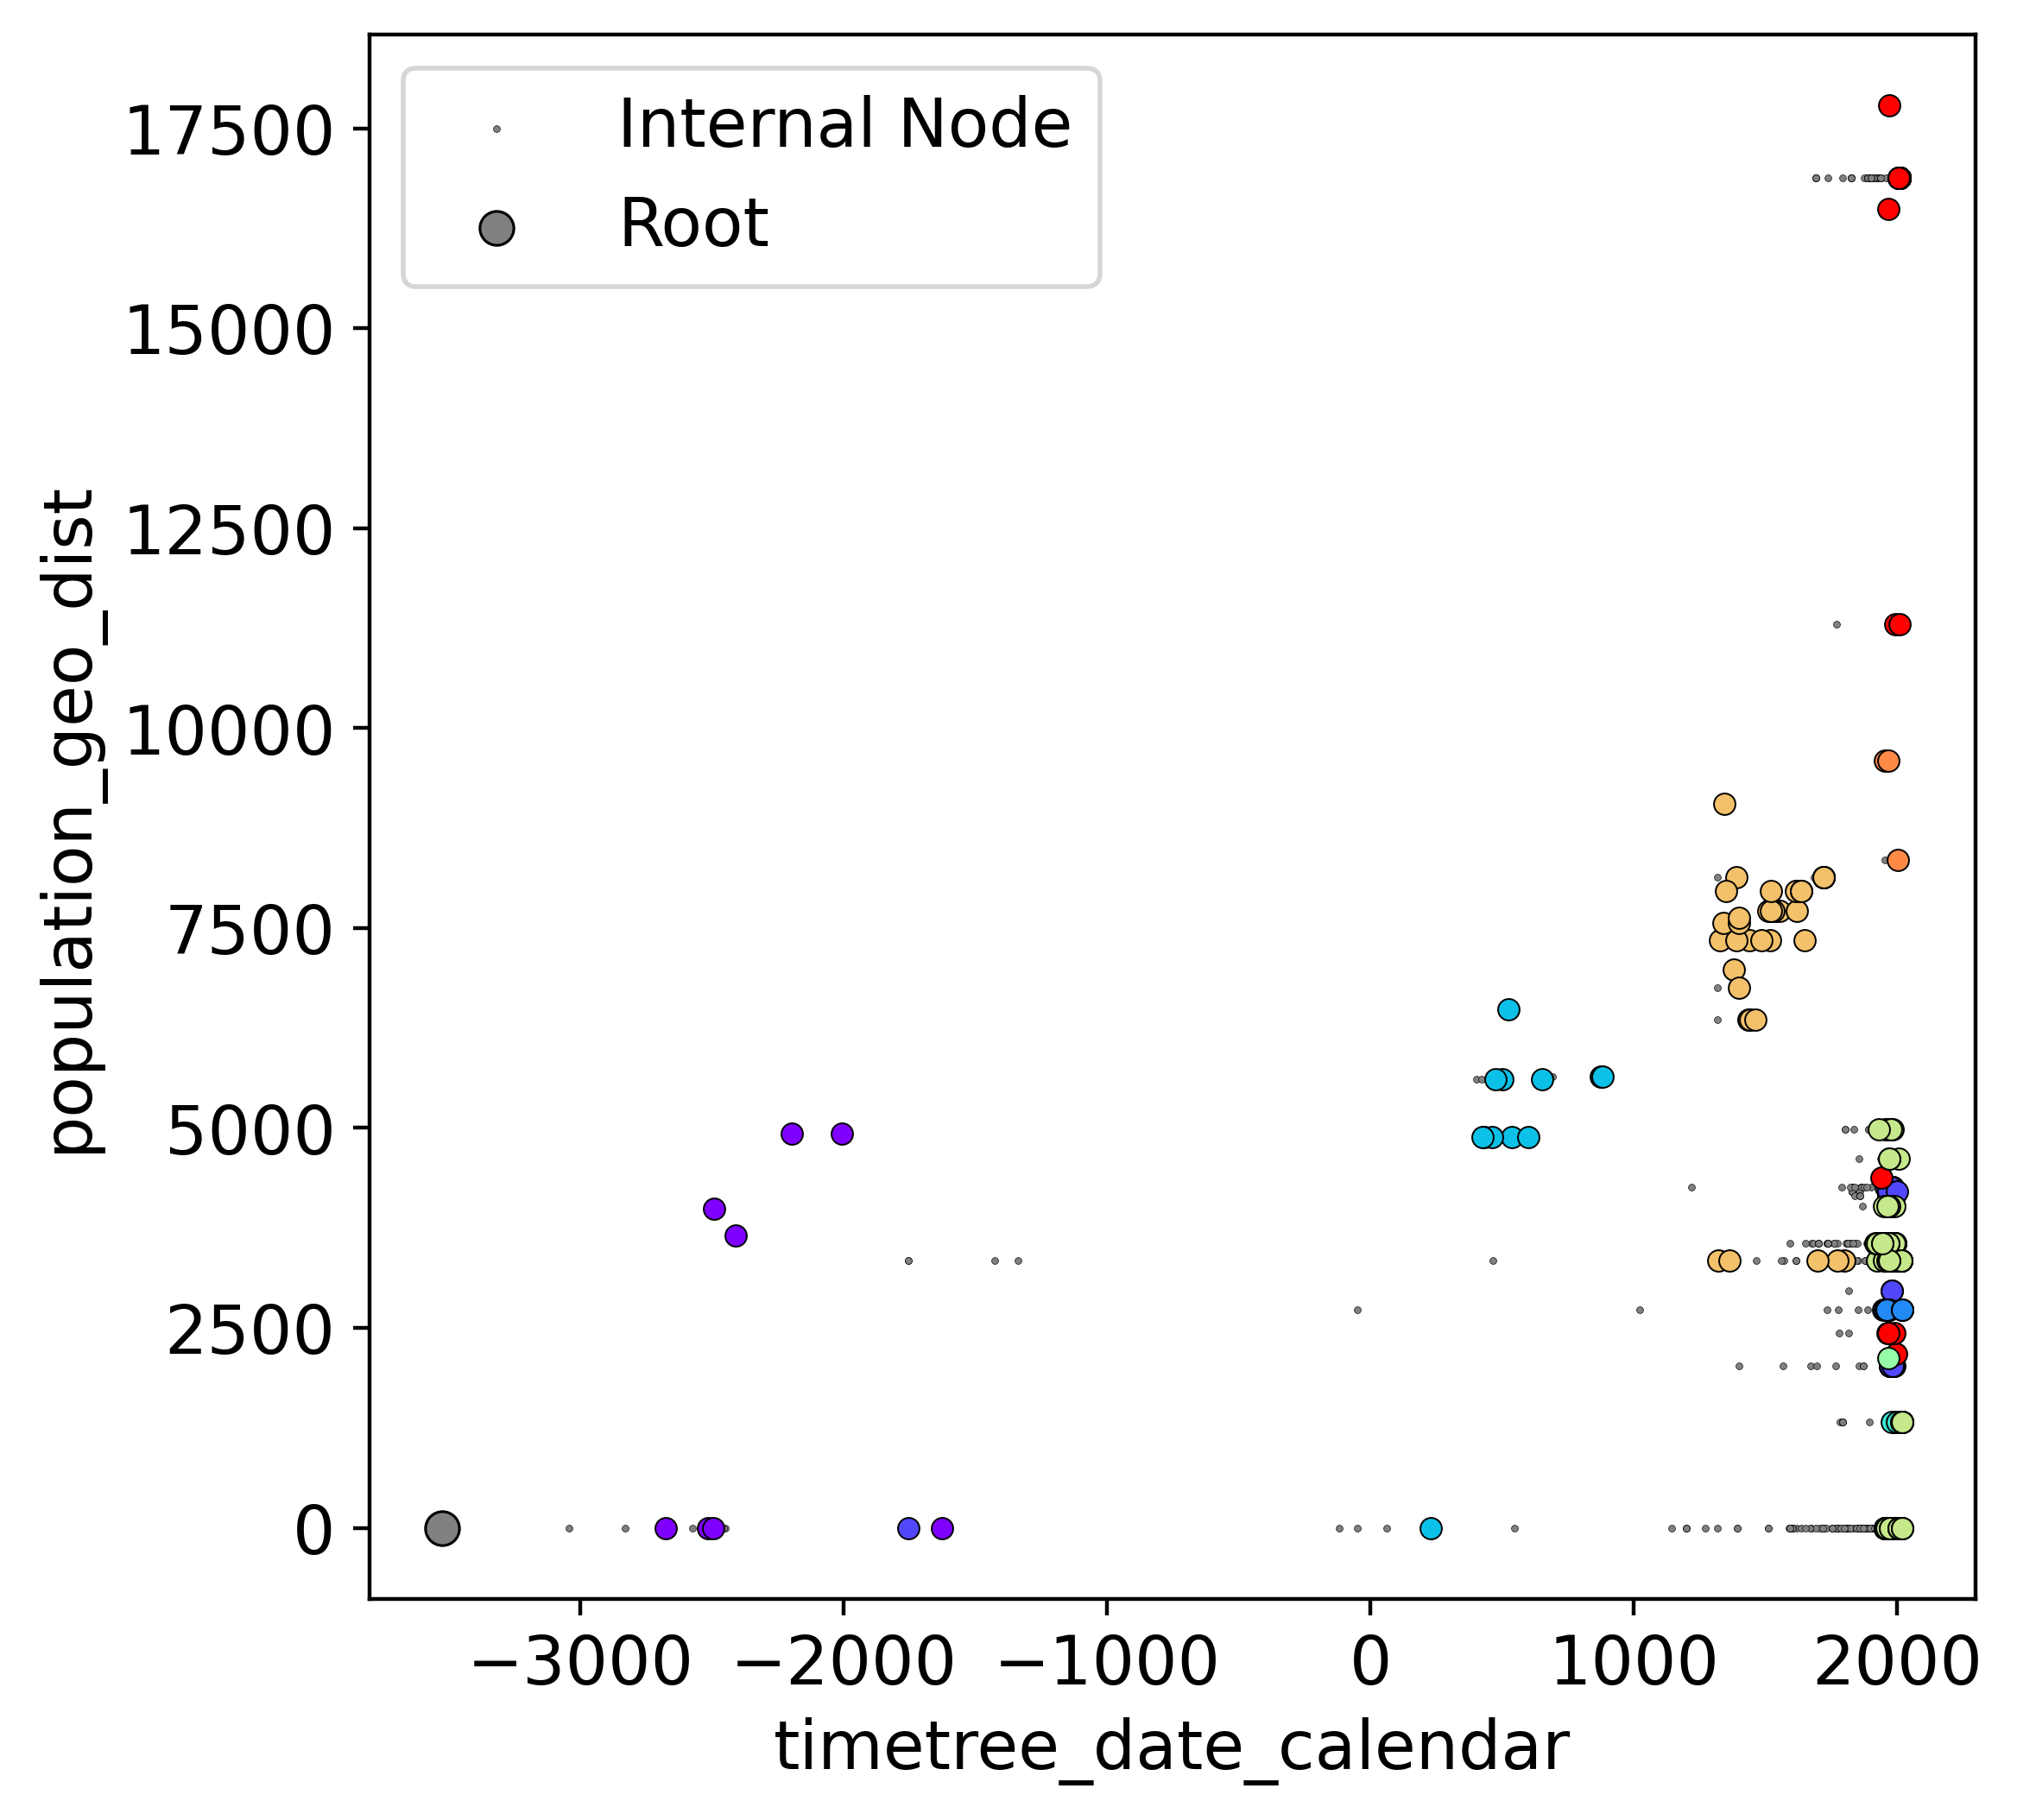

In [32]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[6,6]

fig, ax = plt.subplots(1,dpi=DPI, figsize=FIGSIZE)

internal_df = metadata_df[metadata_df["node_type"] == "internal"]

root_province = metadata_df["mugration_province"]["NODE0"]
print(root_province)
print([metadata_df["timetree_date_calendar"]["NODE0"]])
# All internal nodes

sns.scatterplot(
    ax=ax,  
    data=internal_df,
    x="timetree_date_calendar",
    y="population_geo_dist",
    s=2,
    ec = "black",      
    alpha=1.00,
    zorder=1,
    color="grey",
    label="Internal Node"
)

sns.scatterplot(
    ax=ax,  
    x=[metadata_df["timetree_date_calendar"]["NODE0"]],
    y=[0],
    s=50,
    ec = "black",      
    alpha=1.00,
    zorder=1,
    color="grey",
    label="Root"
)

for population in population_list:
    df = metadata_df[metadata_df["population"] == population]    

    color = df["population_color"][0]
    sns.scatterplot(
        ax=ax,  
        data=df,
        x="timetree_date_calendar",    
        y="population_geo_dist",
        s=20,
        ec = "black",      
        alpha=1.00,
        zorder=2,  
        color=color,
        #rasterized=True, 
    )

0.PRE
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_0.PRE
0.PE
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_0.PE
0.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_0.ANT
0.ANT4
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_0.ANT4
4.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_4.ANT
3.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_3.ANT
1.PRE
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_1.PRE
1.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/f

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_1.IN
1.ORI
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_1.ORI
2.ANT
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_2.ANT
2.MED
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/augur/all/chromosome/full/filter5/ml/rtt_geo_2.MED


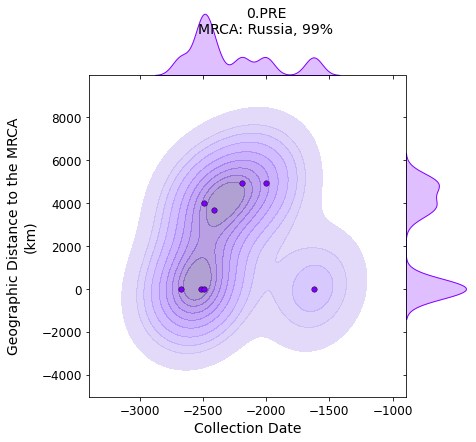

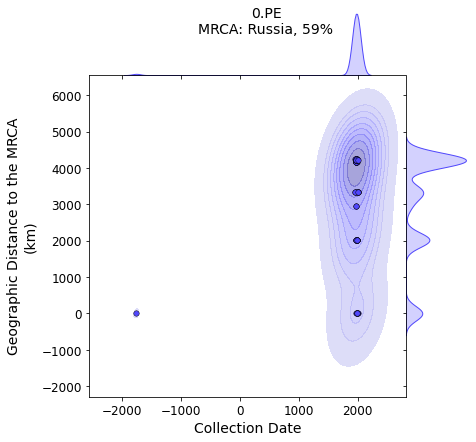

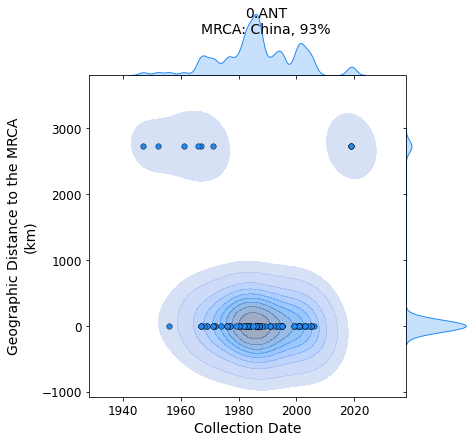

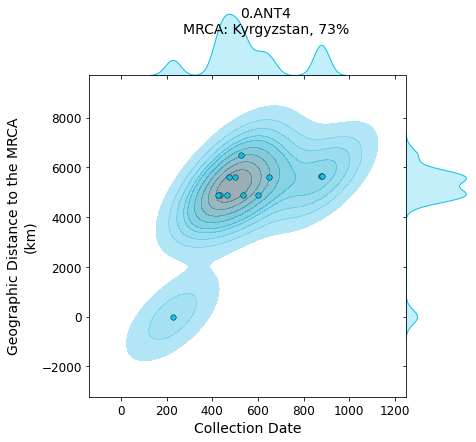

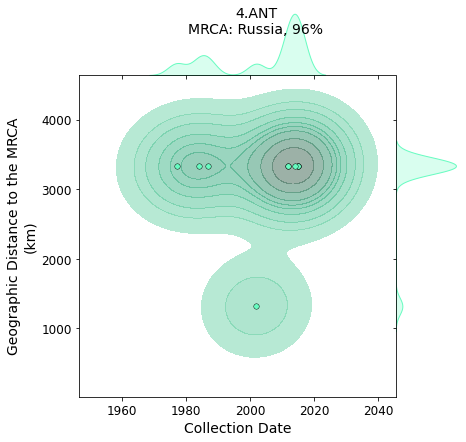

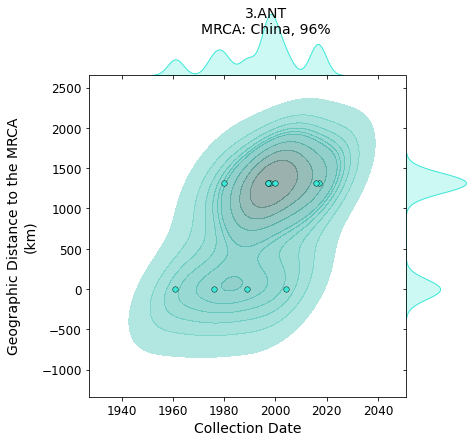

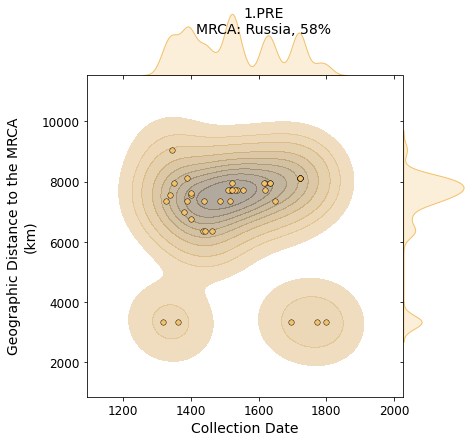

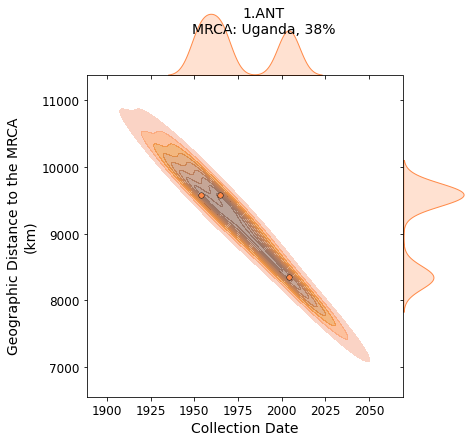

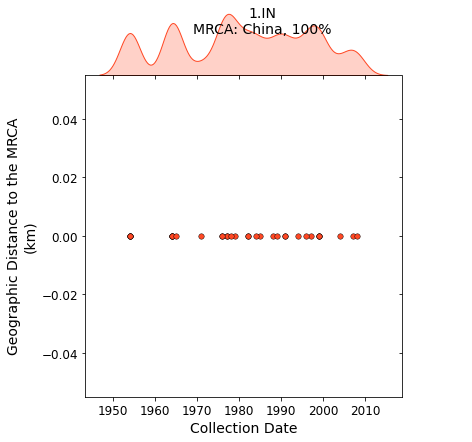

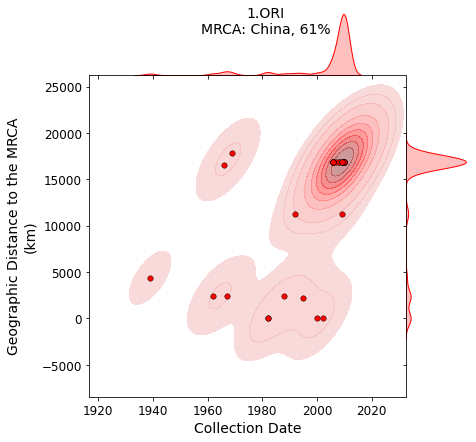

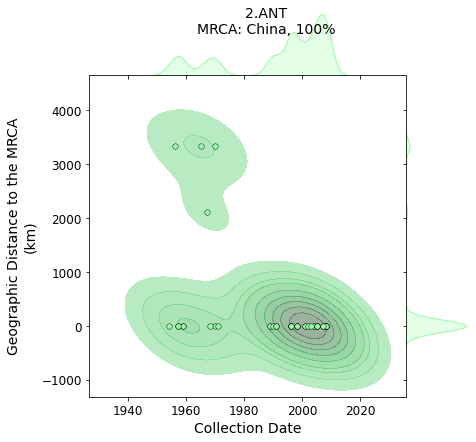

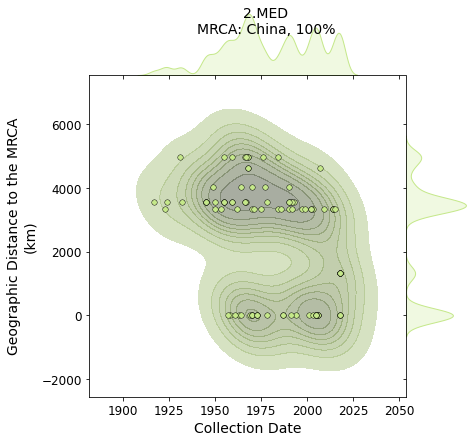

In [33]:
# Plot
for population in population_list:
    df = metadata_df[metadata_df["population"] == population]
    tips=df.index
    
    print(population)

    FONTSIZE=12
    plt.rc('font', size=FONTSIZE)
    DPI=50
    FIGSIZE=[3,3]
    color = df["population_color"][0]

    
    mrca = divtree.common_ancestor(tips)
    mrca_geo = metadata_df["mugration_{}".format(geo_attr)][mrca.name]
    mrca_conf = metadata_df["mugration_{}_confidence".format(geo_attr)][mrca.name]
    
    x=list(df["timetree_date_calendar"])
    y=list(df["population_geo_dist"])
    
    g = sns.JointGrid(       
        x=x, 
        y=y,
        space=0,
    )
        
    g.plot_joint(
        sns.scatterplot,
        color=color,     
        s=30,
        ec = "black",      
        alpha=1.00,
        zorder=2,   
        #rasterized=True, 
    )
    g.plot_joint(
        sns.kdeplot,
        fill=True,
        zorder=1,
        color=color,
        alpha=0.5,
        thresh=0.05,
    )    

    g.plot_marginals(
        sns.kdeplot, 
        bw_adjust=0.3,
        fill=True,
        color=color,
    )
    

    g.fig.suptitle(population + "\nMRCA: {}, {}%".format(mrca_geo, round(mrca_conf * 100)), fontsize=FONTSIZE+2)
        
    g.ax_joint.set_xlabel("Collection Date", fontsize=FONTSIZE+2)
    g.ax_joint.set_ylabel("Geographic Distance to the MRCA\n(km)", fontsize=FONTSIZE+2)
    #g.ax_joint.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
    
    out_path = os.path.join(augur_dir, "rtt_geo_{}".format(population,))
    print(out_path)
    plt.savefig(out_path + ".png", bbox_inches="tight")
    plt.savefig(out_path + ".svg", bbox_inches="tight") 

---
# 4. EXPORT

## Time Tree

In [34]:
out_timetree = copy.deepcopy(timetree)

for c in out_timetree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_timetree, metadata_df)    
out_timetree_nex_path = os.path.join(augur_dir, "all.timetree.nex")
Phylo.write(out_timetree, out_timetree_nex_path, "nexus")

for c in out_timetree.find_clades():
    c.comment = None

out_timetree_nwk_path = os.path.join(augur_dir, "all.timetree.nwk")
Phylo.write(out_timetree, out_timetree_nwk_path, "newick")

1

# Divergence Tree

In [35]:
out_divtree = copy.deepcopy(divtree)

for c in out_divtree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_divtree, metadata_df)    
out_divtree_nex_path = os.path.join(augur_dir, "all.divtree.nex")
Phylo.write(out_divtree, out_divtree_nex_path, "nexus", format_branch_length="%1.10f")

for c in out_divtree.find_clades():
    c.comment = None

out_divtree_nwk_path = os.path.join(augur_dir, "all.divtree.nwk")
Phylo.write(out_divtree, out_divtree_nwk_path, "newick", format_branch_length="%1.10f")

1

## Metadata

In [36]:
out_path_metadata = out_divtree_nwk_path = os.path.join(augur_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)

## Augur

### Reduced Dataframe

In [37]:
# Remember, order mug attrs when dealing with confidence!

columns = [
    # Draw Divergence Tree
    "branch_length",
    "branch_length_sub",
    # Draw Time Tree
    "branch_length_time",
    "timetree_date_calendar",
    "date_mean",
    "date_err",
    "date_bp_mean",    
    # Branch Support
    "branch_support",
    "branch_support_conf_category",  
    "branch_support_conf_char",  
    # Filters
    "branch_minor",
    "node_type",
    "branch_number",
    "host_human",
    # Text Description
    "biosample_accession",
    "strain",
    "country_date_strain",
    "province_date_strain",
    # Stats
    "root_rtt_dist",
    "population_rtt_dist",
    "root_geo_dist",
    "population_geo_dist",
    "rate_sub",
    "rate_sub_year", 
]

for attr in mug_dict:
    mug_colname = "mugration_" + attr
    conf_colname = "mugration_" + attr + "_confidence"
    
    lat_colname = attr + "_lat"
    lon_colname = attr + "_lon"
    if lat_colname in metadata_df.columns:
        lat_colname = "mugration_" + lat_colname
        lon_colname = "mugration_" + lon_colname
        columns.append(lat_colname)
        columns.append(lon_colname)
    
    columns.append(attr)
    columns.append(mug_colname)
    columns.append(conf_colname)
    

# Edit df
auspice_df = copy.copy(metadata_df[columns])
auspice_df["timetree_num_date_confidence"] = [NO_DATA_CHAR] * len(auspice_df)
auspice_df["node_name"] = list(auspice_df.index)
auspice_df["blank"] = [" "] * len(auspice_df)

# Retype mugration confidence and add categories
for attr in mug_dict:
    colname = attr + "_conf_category"
    for rec in auspice_df.iterrows():
        sample = rec[0]
        conf = auspice_df["mugration_" + attr + "_confidence"][sample]
        
        category = "LOW"
        if conf >= 0.95:
            category = "HIGH"
        auspice_df.at[sample, colname] = category
        
        # Recode to str
        #str_conf = str(int(conf * 100))
        #auspice_df.at[sample, "mugration_" + attr + "_confidence"] = str_conf
        
# Date formating
for rec in metadata_df.iterrows():
    sample = rec[0]
    date = rec[1]["timetree_date_calendar"]
    date_lower = float(date) - rec[1]["timetree_CI_lower_err"]
    date_upper = float(date) + rec[1]["timetree_CI_upper_err"]
    date_confidence = [date_lower, date_upper]
    auspice_df.at[sample,"timetree_num_date_confidence"] = date_confidence
    
    # Rounding
    auspice_df.at[sample, "branch_length_sub"] = round(auspice_df["branch_length_sub"][sample])
    auspice_df.at[sample, "branch_length_time"] = round(auspice_df["branch_length_time"][sample])

        
# Rename columns
for attr in mug_dict:
    auspice_df.rename(columns={attr: attr + "_raw"}, inplace=True)    

auspice_df.rename(columns={"timetree_date_calendar": "timetree_num_date"}, inplace=True)
auspice_df.rename(columns={"mugration_country_lat": "country_lat"}, inplace=True)
auspice_df.rename(columns={"mugration_country_lon": "country_lon"}, inplace=True)
auspice_df.rename(columns={"mugration_province_lat": "province_lat"}, inplace=True)
auspice_df.rename(columns={"mugration_province_lon": "province_lon"}, inplace=True)

# Replace no data
#auspice_df.replace(to_replace=NO_DATA_CHAR, value="Not Available", inplace=True)
display(auspice_df)

,branch_length,branch_length_sub,branch_length_time,timetree_num_date,date_mean,date_err,date_bp_mean,branch_support,branch_support_conf_category,branch_support_conf_char,branch_minor,node_type,branch_number,host_human,biosample_accession,strain,country_date_strain,province_date_strain,root_rtt_dist,population_rtt_dist,root_geo_dist,population_geo_dist,rate_sub,rate_sub_year,country_lat,country_lon,country_raw,mugration_country,mugration_country_confidence,province_lat,province_lon,province_raw,mugration_province,mugration_province_confidence,continent_raw,mugration_continent,mugration_continent_confidence,host_order_raw,mugration_host_order,mugration_host_order_confidence,population_raw,mugration_population,mugration_population_confidence,timetree_num_date_confidence,node_name,blank,country_conf_category,province_conf_category,continent_conf_category,host_order_conf_category,population_conf_category
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,3.990000e-06,17.0,224.0,1992.0,1992,0,29,0.0,LOW,,1.ORI1,terminal,1,Human,SAMEA1705942,CO92,United States of America (1992) CO92,United States of America (1992) CO92,7.15499e-05,5.9146e-06,11486.934170,11299.492458,1.784301e-08,0.075740,39.783730,-100.445882,United States of America,United States of America,1.0,38.725178,-105.607716,Colorado,Colorado,1.00,North America,North America,1.0,Human,Human,1.00,1.ORI,1.ORI,1.0,"[1992.0, 1992.0]",Reference,,HIGH,HIGH,HIGH,HIGH,HIGH
GCA_009909635.1_ASM990963v1_genomic,2.112300e-06,9.0,223.0,1923.0,1923,0,98,0.0,LOW,,2.MED1,terminal,2,Human,SAMN13632815,9_10,Russia (1923.0) 9_10,Russia (1923.0) 9_10,7.20581e-05,8.4492e-06,3257.927659,3336.855636,9.459090e-09,0.040152,64.686314,97.745306,Russia,Russia,1.0,47.622245,40.795794,Rostov Oblast,Rostov Oblast,1.00,Europe,Europe,1.0,Human,Human,1.00,2.MED,2.MED,1.0,"[1923.0, 1923.0]",GCA_009909635.1_ASM990963v1_genomic,,HIGH,HIGH,HIGH,HIGH,HIGH
GCA_009669545.1_ASM966954v1_genomic,0.000000e+00,0.0,18.0,2006.0,2006,0,15,0.0,LOW,,0.ANT1,terminal,0,Non-Human,SAMN07722925,42126,China (2006.0) 42126,China (2006.0) 42126,5.41541e-05,1.19379e-05,823.027149,0.000000,0.000000e+00,0.000000,35.000074,104.999927,China,China,1.0,42.480495,85.463346,Xinjiang,Xinjiang,1.00,Asia,Asia,1.0,Rodentia,Rodentia,1.00,0.ANT,0.ANT,1.0,"[2006.0, 2006.0]",GCA_009669545.1_ASM966954v1_genomic,,HIGH,HIGH,HIGH,HIGH,HIGH
GCA_009669555.1_ASM966955v1_genomic,2.347000e-07,1.0,37.0,2005.0,2005,0,16,0.0,LOW,,0.ANT1,terminal,0,Non-Human,SAMN07722924,42123,China (2005.0) 42123,China (2005.0) 42123,5.44828e-05,1.22666e-05,823.027149,0.000000,6.420093e-09,0.027252,35.000074,104.999927,China,China,1.0,42.480495,85.463346,Xinjiang,Xinjiang,1.00,Asia,Asia,1.0,Siphonaptera,Siphonaptera,1.00,0.ANT,0.ANT,1.0,"[2005.0, 2005.0]",GCA_009669555.1_ASM966955v1_genomic,,HIGH,HIGH,HIGH,HIGH,HIGH
GCA_009669565.1_ASM966956v1_genomic,4.694000e-07,2.0,46.0,2005.0,2005,0,16,0.0,LOW,,0.ANT1,terminal,0,Non-Human,SAMN07722923,42118,China (2005.0) 42118,China (2005.0) 42118,5.46235e-05,1.24073e-05,823.027149,0.000000,1.013950e-08,0.043040,35.000074,104.999927,China,China,1.0,42.480495,85.463346,Xinjiang,Xinjiang,1.00,Asia,Asia,1.0,Rodentia,Rodentia,1.00,0.ANT,0.ANT,1.0,"[2005.0, 2005.0]",GCA_009669565.1_ASM966956v1_genomic,,HIGH,HIGH,HIGH,HIGH,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE471,7.041000e-07,3.0,39.0,1916.0,NA,NA,NA,100.0,HIGH,*,NA,internal,NA,NA,NA,NA,NA,NA,NA,NA,3257.927659,3336.855636,1.805815e-08,0.076654,64.686314,97.745306,NA,Russia,1.0,43.088310,47.149880,NA,Republic of Dagestan,0.97,NA,Europe,1.0,NA,Rodentia,0.96,NA,2.MED,1.0,"[1873.0, 1945.0]",NODE471,,HIGH,HIGH,HIGH,HIGH,HIGH
NODE472,4.694000e-07,2.0,4.0,1920.0,NA,NA,NA,100.0,HIGH,*,NA,internal,NA,NA,NA,NA,NA,NA,NA,NA,3257.927659,3336.855636,1.116258e-07,0.473832,64.686314,97.745306,NA,Russia,1.0,43.088310

### JSON

In [40]:
augur_dict = augur_export(
    tree_path=None, 
    aln_path=None,  
    tree=divtree, 
    tree_df=auspice_df, 
    color_keyword_exclude=["geometry"],
    type_convert = {
        "branch_number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])
#print(augur_dict["nodes"]["GCA_002981995.1_ASM298199v1_genomic"])

out_path_augur_json = os.path.join(augur_dir, "all.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'branch_length': 3.99e-06, 'branch_length_sub': 17.0, 'branch_length_time': 224.0, 'num_date': 1992.0, 'date_mean': 1992.0, 'date_err': 0.0, 'date_bp_mean': 29.0, 'branch_support': 0.0, 'branch_support_conf_category': 'LOW', 'branch_support_conf_char': '', 'branch_minor': '1.ORI1', 'node_type': 'terminal', 'branch_number': '1.0', 'host_human': 'Human', 'biosample_accession': 'SAMEA1705942', 'strain': 'CO92', 'country_date_strain': 'United States of America (1992) CO92', 'province_date_strain': 'United States of America (1992) CO92', 'root_rtt_dist': 7.15499e-05, 'population_rtt_dist': 5.9146e-06, 'root_geo_dist': 11486.93417025, 'population_geo_dist': 11299.49245753, 'rate_sub': 1.7843008358040756e-08, 'rate_sub_year': 0.07574039442439529, 'country_lat': 39.7837304, 'country_lon': -100.4458825, 'country_raw': 'United States of America', 'country': 'United States of America', 'country_confidence': {'United States of America': 1.0}, 'province_lat': 38.7251776, 'province_lon': -105.60771

## Auspice

### JSON

In [41]:
#import sys, importlib
#importlib.reload(sys.modules['functions'])
#from functions import auspice_export, branch_attributes

auspice_dict = auspice_export(
    tree=divtree,
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=out_path_colors,
    auspice_latlons_path=out_path_latlon, 
    )


label_col = list(auspice_df.columns)

# Recursively add branch attrs
branch_attributes(
    tree_dict=auspice_dict["tree"], 
    sub_dict=auspice_dict["tree"], 
    df=auspice_df,
    label_col=label_col,
    )

# Last manual changes
auspice_dict_copy = copy.deepcopy(auspice_dict)
for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
    coloring = auspice_dict_copy["meta"]["colorings"][i]
    for key in coloring:
        # Node type as internal or terminal
        if coloring[key] == "node_type":
            auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', '#000000']]
            #print(auspice_dict["meta"]["colorings"][i])
        # Confidence category
        if "conf_category" in coloring[key]:
            auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', '#000000']]
            #print(auspice_dict["meta"]["colorings"][i])
        # Host Human binary
        #if "host_human" in coloring[key]:
        #    auspice_dict["meta"]["colorings"][i]['scale'] = [['Human', '#CBB742'], ['Non-Human', "#60B6F2"], ['NA', "#D6D6D6"]]

        
# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(auspice_dir, "all.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.\n")

#out_path_auspice_remote_json = os.path.join(auspice_dir, "{}_all.json".format(AUSPICE_PREFIX))
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_local_json)
#print("Validation successful for local JSON.\n")

Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/all.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/all.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.



## Subtrees

In [42]:
#import sys, importlib
#importlib.reload(sys.modules['functions'])
#from functions import extract_subtree

for population in population_list:
    timetree_copy = copy.deepcopy(timetree)
    
    # Create the subtree df
    df = metadata_df[metadata_df["population"] == population]
    color = df["population_color"][0]
    
    #if len(subtree_df) < 2: continue
    print(population, color)

    df.sort_values("timetree_coord_y", inplace=True)
    tips = df[df["node_type"] == "terminal"]
    internals = df[df["node_type"] == "internal"]
    
    # ----------------------------------------------
    # Subtree Timetree
    subtree = extract_subtree(
        tree=timetree_copy, 
        tips=list(tips.index), 
        df=metadata_df, 
        color_branches=False)
    
    metadata_to_comment(subtree, metadata_df)   


    out_subtree_nex_path = os.path.join(augur_dir, "{}.timetree.nex".format(population))
    Phylo.write(subtree, out_subtree_nex_path, "nexus")
    out_subtree_nwk_path = os.path.join(augur_dir, "{}.timetree.nwk".format(population))
    Phylo.write(subtree, out_subtree_nwk_path, "newick")
    
    # ----------------------------------------------
    # Subtree divtree
    divtree_copy = copy.deepcopy(divtree)
    subtree_div = extract_subtree(
        tree=divtree_copy, 
        tips=list(tips.index), 
        df=metadata_df, 
        color_branches=False)
    
    metadata_to_comment(subtree_div, metadata_df)   
    out_subtree_path = os.path.join(augur_dir, "{}.divtree.nex".format(population))
    Phylo.write(subtree, out_subtree_path, "nexus", format_branch_length="%1.10f")

    #fig, ax = plt.subplots(1)
    #Phylo.draw(subtree, axes=ax, show_confidence=False, label_func = lambda x: '', do_show=False)
    
    augur_dict = augur_export(
        tree_path=None, 
        aln_path=None,  
        tree=subtree, 
        tree_df=auspice_df, 
        color_keyword_exclude=["geometry"],
        type_convert = {
            "branch_number" : (lambda x : str(x))
        },
    ) 
        
    out_path_augur_json = os.path.join(augur_dir, "{}.json".format(population) )
    utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

    auspice_dict = auspice_export(
        tree=subtree,
        augur_json_paths=[out_path_augur_json], 
        auspice_config_path=auspice_config_path, 
        auspice_colors_path=out_path_colors,
        auspice_latlons_path=out_path_latlon, 
        )    
    
    label_col = list(auspice_df.columns)

    # Recursively add branch attrs
    branch_attributes(
        tree_dict=auspice_dict["tree"], 
        sub_dict=auspice_dict["tree"], 
        df=auspice_df,
        label_col=label_col,
        )    
    
    # Last manual changes
    auspice_dict_copy = copy.deepcopy(auspice_dict)
    for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
        coloring = auspice_dict_copy["meta"]["colorings"][i]
        for key in coloring:
            # Node type as internal or terminal
            if coloring[key] == "node_type":
                auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Confidence category
            if "conf_category" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', color]]
                #print(auspice_dict["meta"]["colorings"][i]) 
    
    # Write outputs - For Local Rendering
    out_path_auspice_local_json = os.path.join(auspice_dir, "{}.json".format(population) )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_local_json)
    print("Validation successful for local JSON.\n")

0.PRE #8000ff


DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.PRE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.









A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.PE #5148fc
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.PE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.PE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

0.ANT #238af5



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

0.ANT4 #0cc1e8



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.
Validating produced JSON


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.ANT4.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/0.ANT4.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

4.ANT #68fcc1



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/4.ANT.json'...


Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/4.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

3.ANT #3ae8d7



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/3.ANT.json'...


Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/3.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.PRE #f3c16a



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.PRE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.ANT #ff8a48
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy







A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.IN #ff4824
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.IN.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.IN.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.ORI #ff0000



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.ORI.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/1.ORI.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

2.ANT #97fca7



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/2.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/2.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

2.MED #c5e88a



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/2.MED.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main_filter/auspice/all/chromosome/full/filter5/ml/2.MED.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

